# DATA512 Homework A1
## Ryan Williams

## Step 1. Data acquisition
This section calls two APIs (the pagecount API and pageview API) to collect Wikipedia traffic data from 2007 to 2021

The results of the API calls are written into 5 separate JSON files (pagecount results separated into desktop and mobile, pageview results separated into desktop, mobile web, and mobile app)

In [1]:
import json
import requests

In [2]:
# set API endpoints
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [3]:
# parameters for getting aggregated legacy view data 
## desktop
params_legacy_desktop = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2001010100",
                # for end use 1st day of month following final month of data
                 "end" : "2021090100"
                    }

## mobile
params_legacy_mobile = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2001010100",
                # for end use 1st day of month following final month of data
                 "end" : "2021090100"
                    }

# parameters for getting aggregated current standard pageview data
## desktop
params_pageviews_desktop = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2021091000'
                        }

## mobile web
params_pageviews_mobileweb = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2021091000'
                        }

## mobile app
params_pageviews_mobileapp = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2021091000'
                        }

# add headers
headers = {
    'User-Agent': 'https://github.com/lawrywill',
    'From': 'lrw0102@uw.edu'
}

In [4]:
# function for calling API
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

# function for calling api and writing results to Json
def call_and_write(endpoint, parameters, filename):
    # call api to get data
    data = api_call(endpoint, parameters)
    
    # write to json file
    jsonString = json.dumps(data, indent = 2)
    jsonFile = open(filename, "w")
    jsonFile.write(jsonString)
    jsonFile.close()

In [5]:
# call the API and write the results to 5 individual Json files
call_and_write(endpoint_legacy, params_legacy_desktop, "pagecounts_desktop-site_200712-202109.json")
call_and_write(endpoint_legacy, params_legacy_mobile, "pagecounts_mobile-site_200712-202109.json")
call_and_write(endpoint_pageviews, params_pageviews_desktop, "pageviews_desktop_200712-202109.json")
call_and_write(endpoint_pageviews, params_pageviews_mobileweb, "pageviews_mobile-web_200712-202109.json")
call_and_write(endpoint_pageviews, params_pageviews_mobileapp, "pageviews_mobile-app_200712-202109.json")

## Step 2. Data processing
This section prepares the raw data for analysis by taking the following steps:
1. Read in the JSON files converted to Pandas dataframes
2. Drop the extraneous columns in the individual dataframes, leaving only timestamp and view count
3. Join all 5 dataframes together on the timestamp
4. Sum up columns such that we have total views, desktop views, and mobile views for both the pagecount and pageview data
5. Split the timestamp into year and month
6. Drop all extraneous columns
7. Write the results to CSV

In [6]:
import pandas as pd

In [7]:
# function for reading in json files as pandas df
def json_to_df(filename):
    with open(filename,'r') as f:
        data = json.loads(f.read())

    return pd.json_normalize(data, record_path =['items'])

In [8]:
# read in json files and prepare them for joining
# pagecount desktop
pagecount_d = json_to_df("pagecounts_desktop-site_200712-202109.json")
pagecount_d = pagecount_d.rename(columns={'count':'pagecount_desktop_views'}).drop(columns={'project','access-site','granularity'})

# pagecount mobile
pagecount_m = json_to_df("pagecounts_mobile-site_200712-202109.json")
pagecount_m = pagecount_m.rename(columns={'count':'pagecount_mobile_views'}).drop(columns={'project','access-site','granularity'})

# pageview desktop
pageview_d = json_to_df("pageviews_desktop_200712-202109.json")
pageview_d = pageview_d.rename(columns={'views':'pageview_desktop_views'}).drop(columns={'project','access','agent','granularity'})

# pageview mobile web
pageview_mw = json_to_df("pageviews_mobile-web_200712-202109.json")
pageview_mw = pageview_mw.rename(columns={'views':'pageview_mobile-web_views'}).drop(columns={'project','access','agent','granularity'})

# pageview mobile web
pageview_ma = json_to_df("pageviews_mobile-app_200712-202109.json")
pageview_ma = pageview_ma.rename(columns={'views':'pageview_mobile-app_views'}).drop(columns={'project','access','agent','granularity'})

In [9]:
# join data
df = pagecount_d.merge(pagecount_m, on = ['timestamp'], how = 'outer')
df = df.merge(pageview_d, on = ['timestamp'], how = 'outer')
df = df.merge(pageview_mw, on = ['timestamp'], how = 'outer')
df = df.merge(pageview_ma, on = ['timestamp'], how = 'outer')

In [10]:
# create combined columns
df = df.fillna(0)
df['pageview_mobile_views'] = df['pageview_mobile-web_views'] + df['pageview_mobile-app_views']
df['pageview_all_views'] = df['pageview_desktop_views'] + df['pageview_mobile_views']
df['pagecount_all_views'] = df['pagecount_desktop_views'] + df['pagecount_mobile_views']

# separate timestamp
df['year'] = df['timestamp'].str[:4]
df['month'] = df['timestamp'].str[4:6]

# reorder and drop extraneous columns
df = df[['year','month','pagecount_all_views','pagecount_desktop_views','pagecount_mobile_views','pageview_all_views','pageview_desktop_views','pageview_mobile_views']]

In [11]:
# write to csv
df.to_csv("en-wikipedia_traffic_200712-202108.csv", index = False)

## Step 3. Analysis

This section plots our wikipedia data by taking the following steps:
1. Read in the CSV we created
2. Format the date in (YYYY-MM) format to be more conducive to plotting
3. Sum up our pagecount and pageview columns for all traffic, mobile traffic, and desktop traffic
4. Plot the results in matplotlib
5. Save the plot as a PNG file

In [12]:
import matplotlib.pyplot as plt

In [13]:
# read in data
df = pd.read_csv("en-wikipedia_traffic_200712-202108.csv")

# remove 2007
df= df[df['year'] >= 2008]

# create combined columns for plotting
time = df['year'].astype(str)+"-"+df['month'].astype(str).apply(lambda x: x.zfill(2))
allViews = df['pagecount_all_views']+df['pageview_all_views']
dtViews = df['pagecount_desktop_views']+df['pageview_desktop_views']
moViews = df['pagecount_mobile_views']+df['pageview_mobile_views']

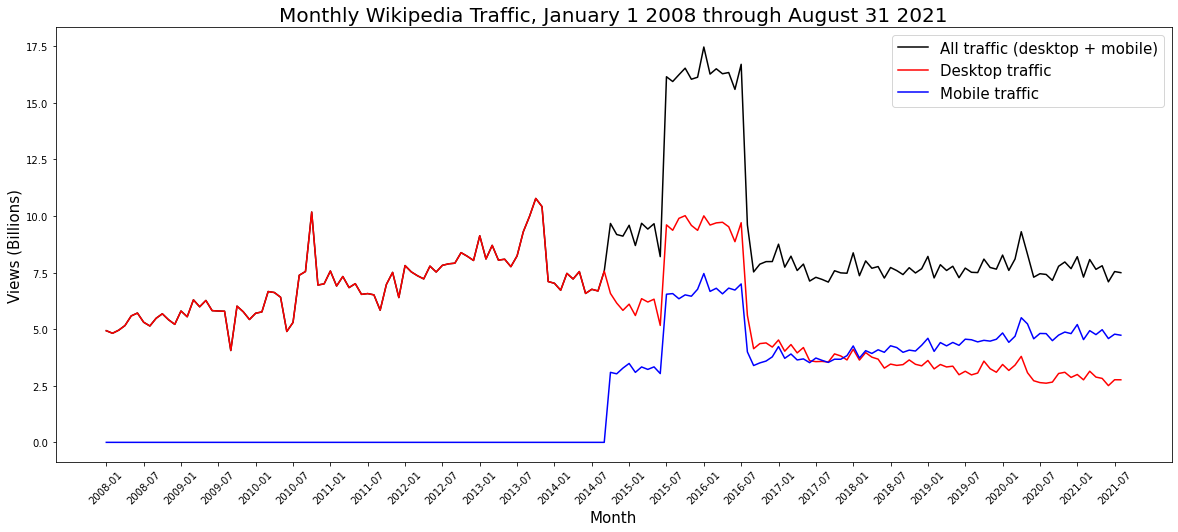

In [14]:
# plot our data
plt.figure(figsize=(20, 8))

plt.plot(time,allViews*1e-9, color = "k", label = "All traffic (desktop + mobile)")
plt.plot(time,dtViews*1e-9, color = "r", label = "Desktop traffic")
plt.plot(time,moViews*1e-9, color = "b", label = "Mobile traffic")
plt.title('Monthly Wikipedia Traffic, January 1 2008 through August 31 2021', size = 20)
plt.xlabel('Month', size = 15)
plt.xticks(time[::6], rotation = 45)
plt.ylabel('Views (Billions)', size = 15)
plt.legend(prop={'size': 15})
plt.ticklabel_format(axis="y", style="plain")
plt.savefig(fname = 'en-wikipedia_traffic_200712-202108.png')

plt.show()